<a href="https://colab.research.google.com/github/Shrutiba/iisc_cds/blob/main/M2_NB_MiniProject_5_Customer_Segmentation_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Customer segmentation using clustering

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

## Grading = 10 Points

### Import Required packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy import stats

## Data Wrangling

In [2]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
!unzip -qq Online_Retail.zip

## Load the data

In [160]:
# YOUR CODE HERE
df = pd.read_csv('Online_Retail_Train.csv', encoding = 'unicode_escape')
# Change the data type of CustomerID to object as it is categorical variable
df['CustomerID'] = df['CustomerID'].astype(str)
# Replace empty strings and 'nan' strings with actual NaN
df['CustomerID'] = df['CustomerID'].replace({'': np.nan, 'nan': np.nan})


In [162]:
df_test = pd.read_csv('Online_Retail_Test.csv', encoding = 'unicode_escape')
# Change the data type of CustomerID to object as it is categorical variable
df_test['CustomerID'] = df_test['CustomerID'].astype(str)
# Replace empty strings and 'nan' strings with actual NaN
df_test['CustomerID'] = df_test['CustomerID'].replace({'': np.nan, 'nan': np.nan})

In [166]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,Monday
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,Wednesday
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,Thursday


In [ ]:
df.info()

## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://thecleverprogrammer.com/2023/07/26/detect-and-remove-outliers-using-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [7]:
def get_duplicate_row_count(data):
    invoice_count = data.groupby(['InvoiceNo','StockCode']).size().reset_index(name='count')
    return invoice_count['count'].value_counts()

In [65]:
def getRowCountWithNoCustomerID(data):
    return len(data[data['CustomerID'].isnull()])

In [9]:
def getRowCountWithStockCodeS(data):
    return ((data['StockCode'] == 'S') & (data['CustomerID'] != 'nan')).sum()

In [10]:
def getRowCountWithIrrelevantStockCode(data):
    return data['StockCode'].isin(['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']).sum()

In [136]:
def getRowsWithQuantityOutliers(data, threshold = 2):
    z_scores = np.abs(stats.zscore(data['Quantity']))
    # Filter the data based on z-score threshold
    return data[z_scores > threshold]

In [137]:
def getRowsWithUnitPriceOutliers(data, threshold = 2):
    z_scores = np.abs(stats.zscore(data['UnitPrice']))
    # Filter the data based on z-score threshold
    return data[z_scores > threshold]

In [129]:
def data_preprocessing(data):

# Drop duplicates by comparing all the fields
    data.drop_duplicates(inplace=True)
    data.drop(data[data['CustomerID'].isnull()].index, inplace=True)

    rows = data[data['StockCode'].isin(['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES'])]
    data.drop((rows).index, inplace=True)

# As the no. of outliers is very small, I decided to remove the rows with outliers
    outlier_index_quantity = getRowsWithQuantityOutliers(data).index
    data.drop(outlier_index_quantity, inplace=True)

    outlier_index_unitprice = getRowsWithUnitPriceOutliers(data).index
    data.drop(outlier_index_unitprice, inplace=True)

# Add DayOfWeek Column
    # Convert 'InvoiceDate' to datetime objects
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

    # Create the 'DayOfWeek' column
    data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()


In [163]:
def boxplot_preprocessing(original_quantity_range,original_unitprice_range,df):

    # Box plot for Quantity
    plt.figure(figsize=(5, 4))  # Adjust figure size if needed
    sns.boxplot(x=df['Quantity'])
    plt.title('Box Plot of Quantity Before Preprocessing')
    plt.xlabel('Quantity')
    plt.xlim(original_quantity_range)
    plt.show()

    # Box plot for UnitPrice
    plt.figure(figsize=(5, 4))  # Adjust figure size if needed
    sns.boxplot(x=df['UnitPrice'])
    plt.title('Box Plot of UnitPrice Before Preprocessing')
    plt.xlabel('UnitPrice')
    plt.xlim(original_unitprice_range)
    plt.show()

In [150]:
def before_preprocessing(df):
    print("BEFORE PREPROCESSING")
    print(f"No. of duplicate rows with count: {get_duplicate_row_count(df)}")
    print(f"No. of rows with no customer ID: {getRowCountWithNoCustomerID(df)}")
    print(f"No. of rows with Sample StockCode and customer ID is not null: {getRowCountWithStockCodeS(df)}")
    print(f"No. of rows with irrelevant StockCodes: {getRowCountWithIrrelevantStockCode(df)}")
    print(f"Z Score of Quantity: {getRowsWithQuantityOutliers(df)['Quantity'].count()}")
    print(f"Z Score of UnitPrice: {getRowsWithUnitPriceOutliers(df)['UnitPrice'].count()}")

In [149]:
def after_preprocessing(df):

    print("AFTER PREPROCESSING")
    print(f"No. of duplicate rows with count: {get_duplicate_row_count(df)}")
    print(f"No. of rows with no customer ID: {getRowCountWithNoCustomerID(df)}")
    print(f"No. of rows with Sample StockCode and customer ID is not null: {getRowCountWithStockCodeS(df)}")
    print(f"No. of rows with irrelevant StockCodes: {getRowCountWithIrrelevantStockCode(df)}")


In [ ]:
# Process Training Data
original_quantity_range = (df['Quantity'].min(), df['Quantity'].max())
original_unitprice_range = (df['UnitPrice'].min(), df['UnitPrice'].max())

boxplot_preprocessing(original_quantity_range,original_unitprice_range,df)
before_preprocessing(df)
data_preprocessing(df)
after_preprocessing(df)
boxplot_preprocessing(original_quantity_range,original_unitprice_range,df)

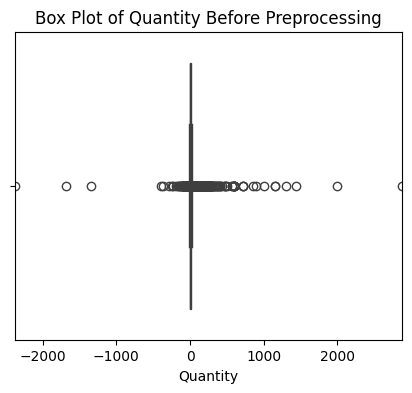

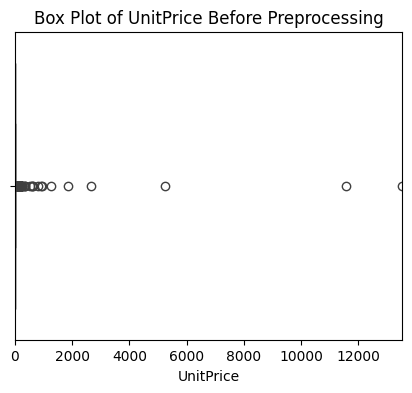

BEFORE PREPROCESSING
No. of duplicate rows with count: count
1    27047
2       23
3        1
Name: count, dtype: int64
No. of rows with no customer ID: 6817
No. of rows with Sample StockCode and customer ID is not null: 1
No. of rows with irrelevant StockCodes: 137
Z Score of Quantity: 433
Z Score of UnitPrice: 18
AFTER PREPROCESSING
No. of duplicate rows with count: count
1    19811
2        8
Name: count, dtype: int64
No. of rows with no customer ID: 0
No. of rows with Sample StockCode and customer ID is not null: 0
No. of rows with irrelevant StockCodes: 0


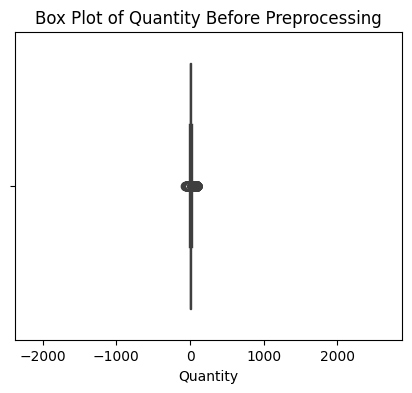

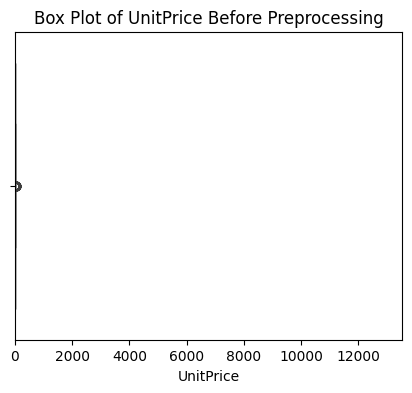

In [165]:
# Process Test Data
original_quantity_range_test = (df_test['Quantity'].min(), df_test['Quantity'].max())
original_unitprice_range_test = (df_test['UnitPrice'].min(), df_test['UnitPrice'].max())

boxplot_preprocessing(original_quantity_range_test,original_unitprice_range_test,df_test)
before_preprocessing(df_test)
data_preprocessing(df_test)
after_preprocessing(df_test)
boxplot_preprocessing(original_quantity_range_test,original_unitprice_range_test,df_test)

## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [167]:
# YOUR CODE HERE
# Check Free Items in the Data
print(len(df[df['UnitPrice'] == 0]))
#Answer : Yes

30


In [169]:
#Transactions per Country
transactions_per_country = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)


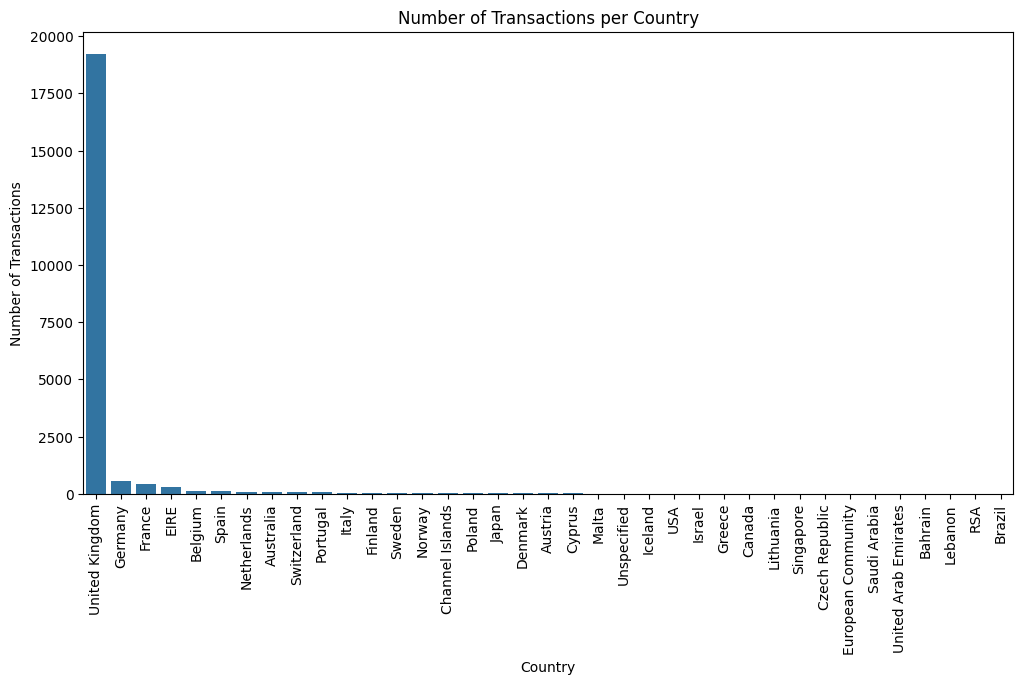

In [170]:
# Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=transactions_per_country.index, y=transactions_per_country.values)
plt.title('Number of Transactions per Country')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

#Answer : Mostly Data is from UK. Data is Skewed w.r.t country

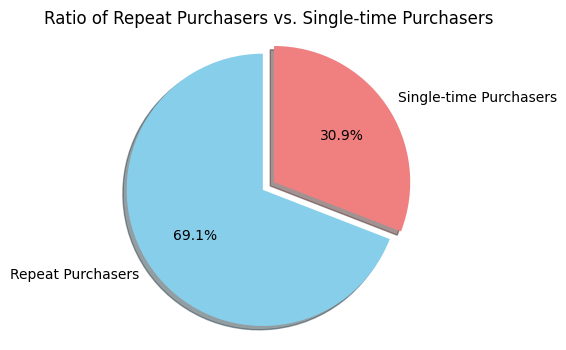

In [179]:
# Repeat purchase vs Single Time Purchase
purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
repeat_purchase = purchase_frequency[purchase_frequency > 1].count()
single_time_purchase = purchase_frequency[purchase_frequency == 1].count()

total_customer = repeat_purchase + single_time_purchase
repeat_ratio = repeat_purchase / total_customer
single_time_ratio = single_time_purchase / total_customer

# Visualize using a pie chart
labels = ['Repeat Purchasers', 'Single-time Purchasers']
sizes = [repeat_ratio, single_time_ratio]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # Explode the first slice (Repeat Purchasers)

plt.figure(figsize=(4, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Ratio of Repeat Purchasers vs. Single-time Purchasers')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [ ]:
# YOUR CODE HERE

### Scale the data

Apply `StandardScaler` on the features.

In [ ]:
# YOUR CODE HERE for scaling

## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [ ]:
# YOUR CODE HERE to apply KMeans

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

In [ ]:
# YOUR CODE HERE

### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [ ]:
# YOUR CODE HERE

### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

In [ ]:
# YOUR CODE HERE

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [ ]:
# YOUR CODE HERE

### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [ ]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)

In [ ]:
# YOUR CODE HERE

### Report Analysis

- Discuss the pros and cons of removing the missing values vs replacing with the mean values
- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster
- What other methods could be used to determine the optimal no. of clusters?